In [1]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from scipy.stats import skew

In [4]:
path = kagglehub.dataset_download("itsmesunil/bank-loan-modelling")
xls = pd.ExcelFile('/kaggle/input/bank-loan-modelling/Bank_Personal_Loan_Modelling.xlsx')
df = pd.read_excel(xls, sheet_name='Data')

In [5]:
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [6]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,2500.500000,45.338400,20.104600,73.774200,93152.503000,2.396400,1.937913,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,1443.520003,11.463166,11.467954,46.033729,2121.852197,1.147663,1.747666,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,1250.750000,35.000000,10.000000,39.000000,91911.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,2500.500000,45.000000,20.000000,64.000000,93437.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,3750.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


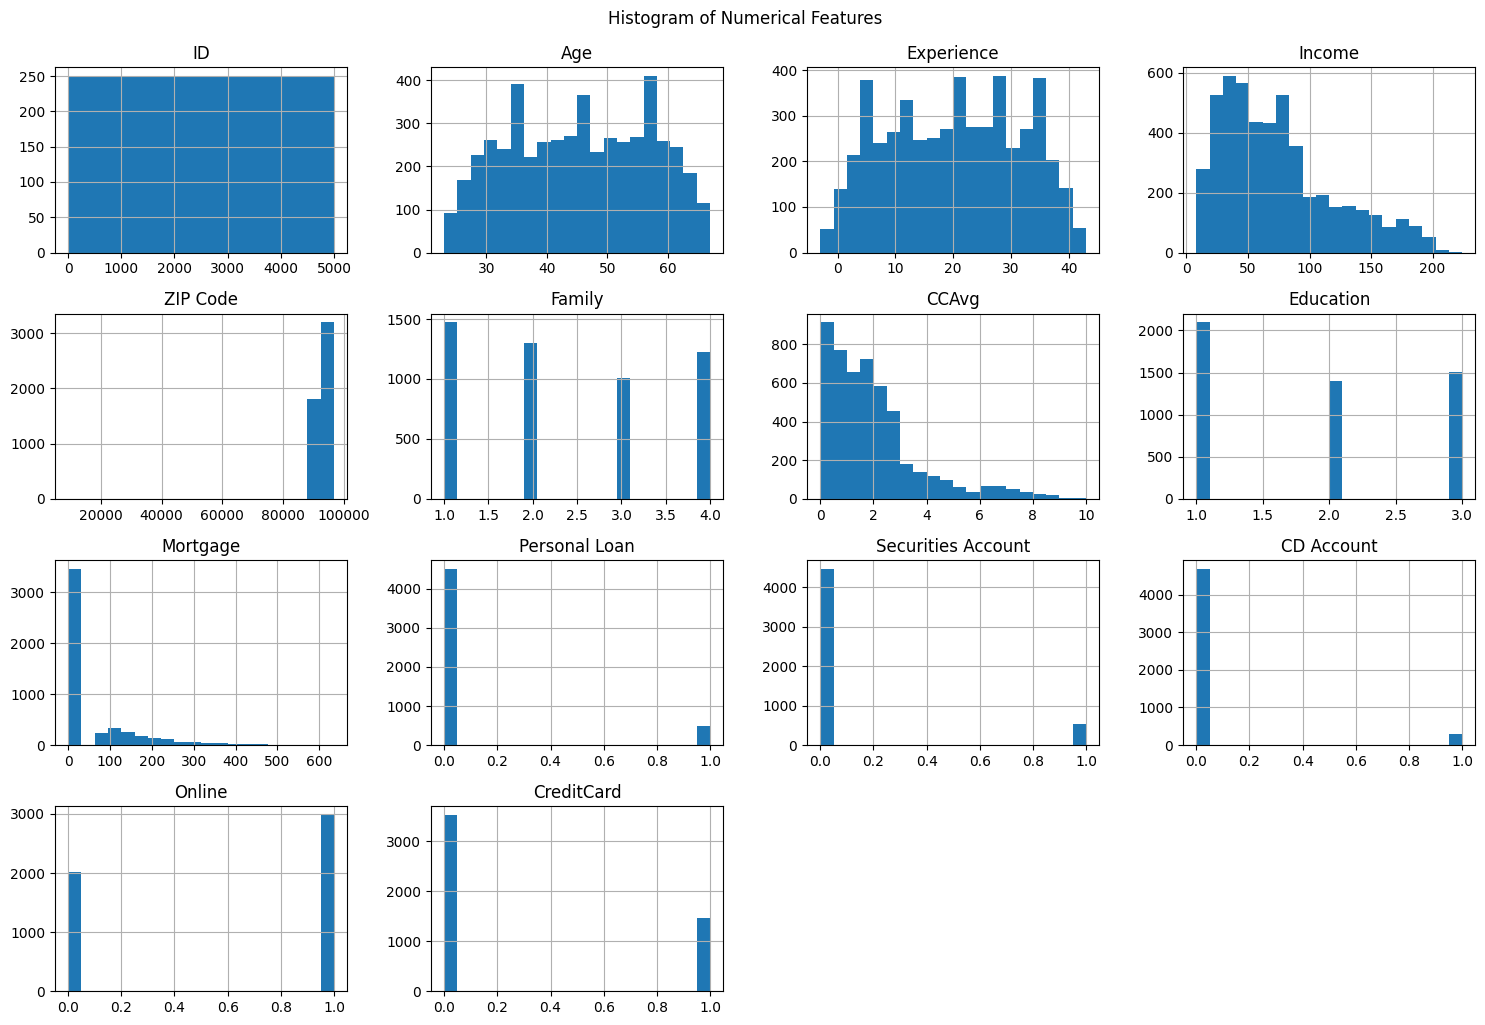

In [7]:

df.hist(figsize=(15, 10), bins=20)
plt.tight_layout()
plt.suptitle("Histogram of Numerical Features", y=1.02)
plt.show()

In [8]:
categorical_cols = ['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard']


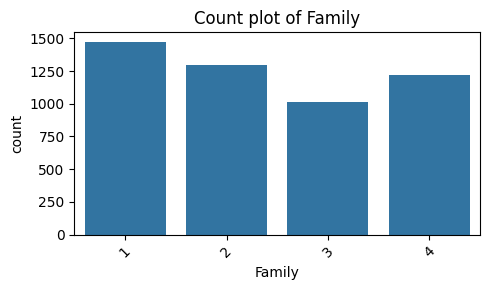

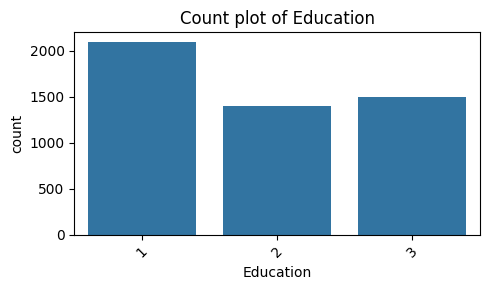

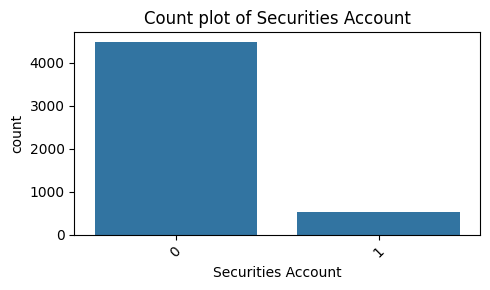

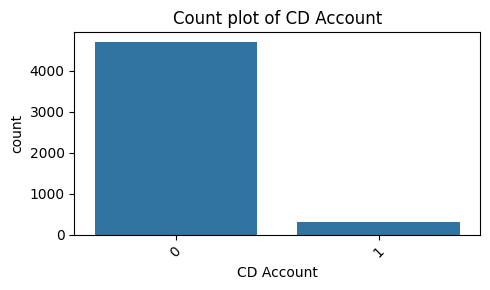

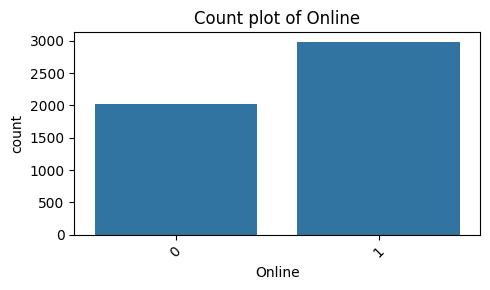

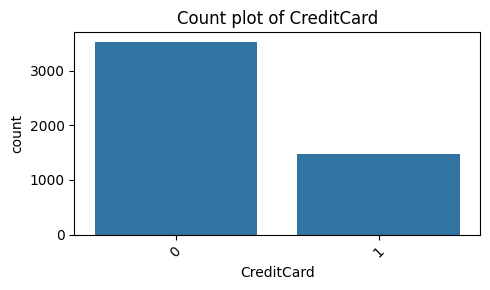

In [9]:
for col in categorical_cols:
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df, x=col)
    plt.title(f'Count plot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


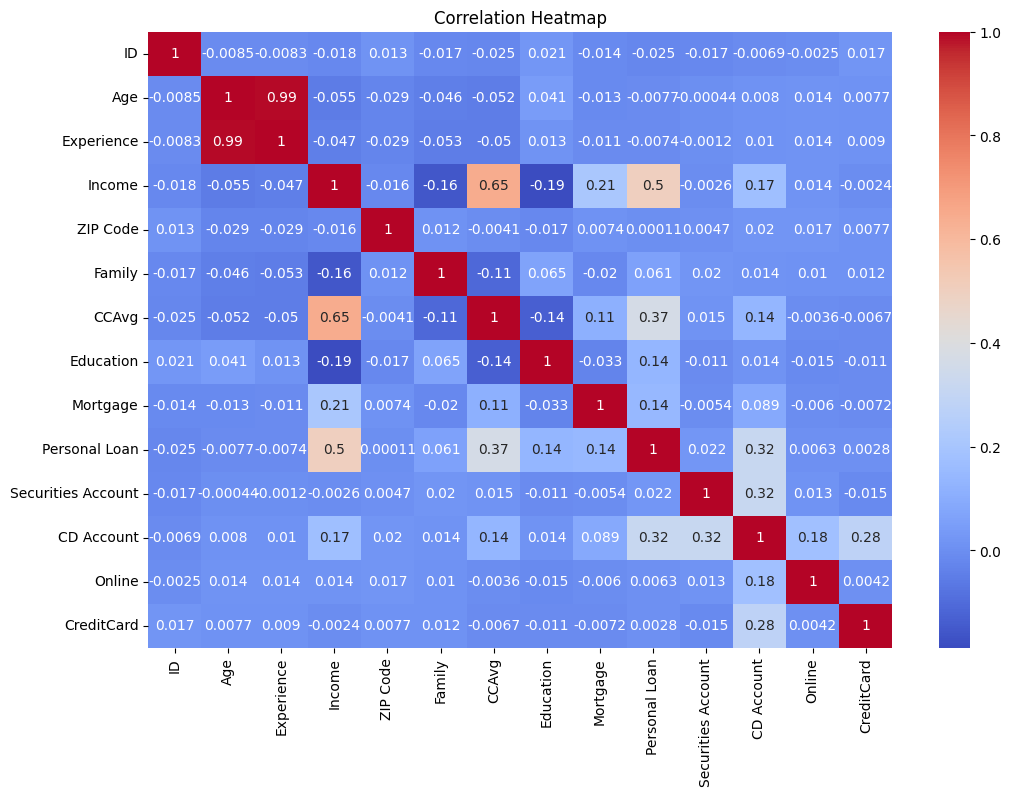

In [10]:
plt.figure(figsize=(12, 8))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

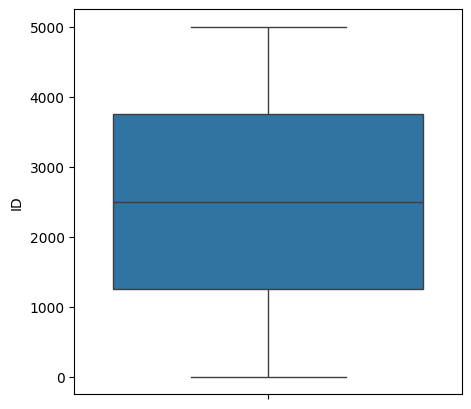

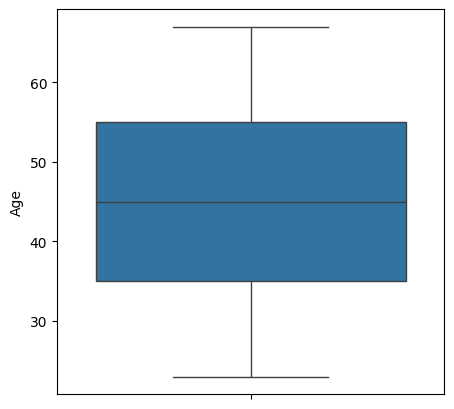

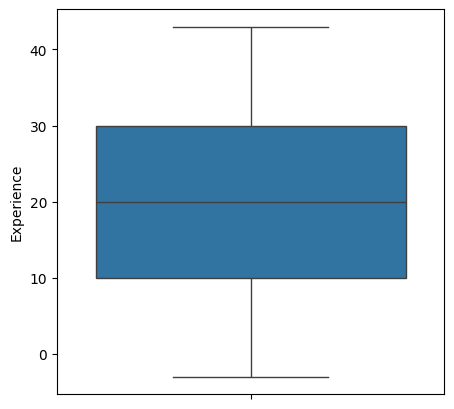

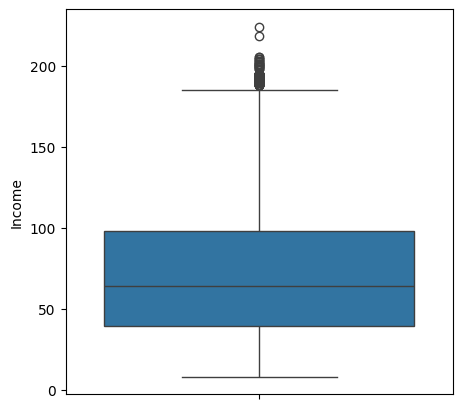

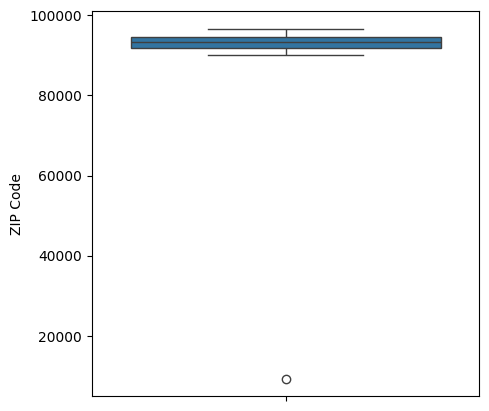

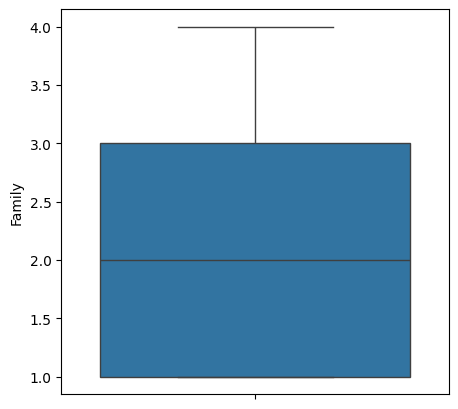

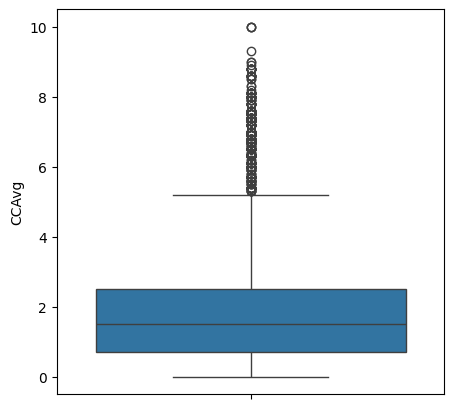

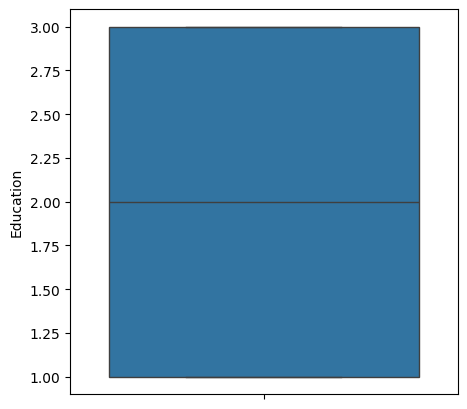

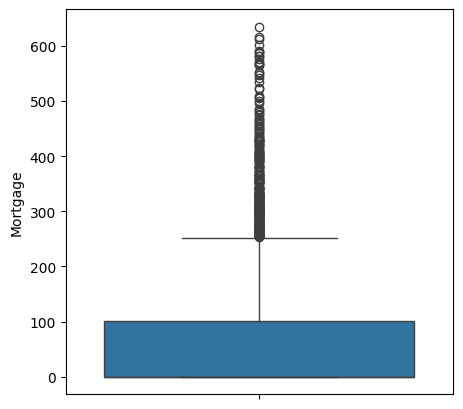

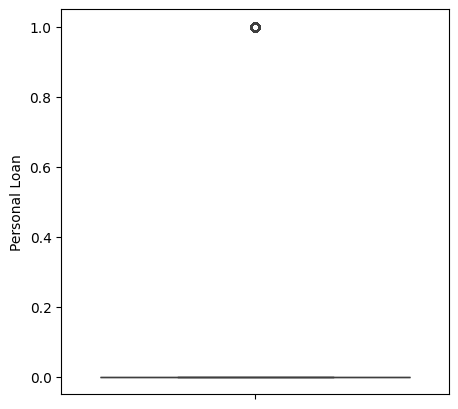

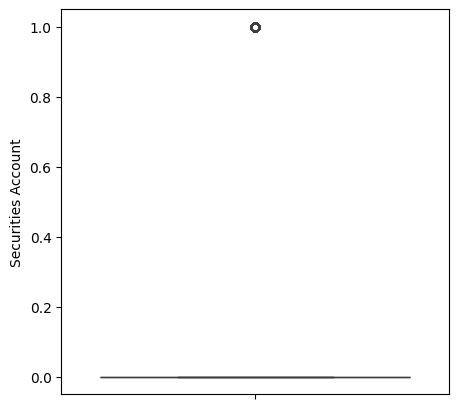

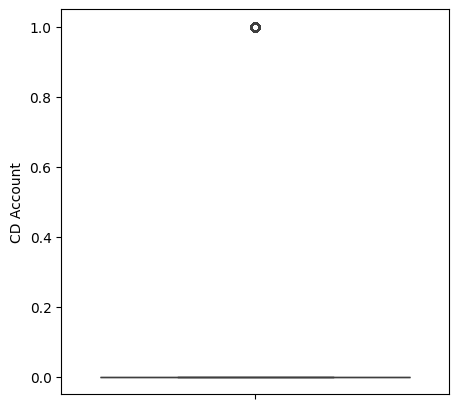

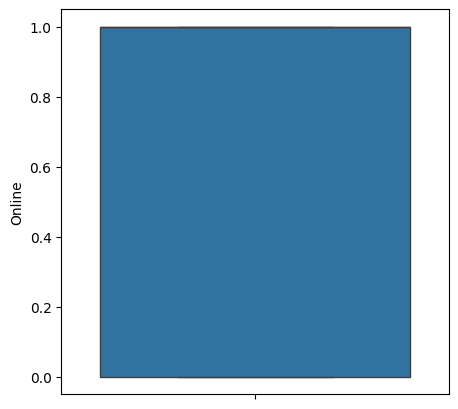

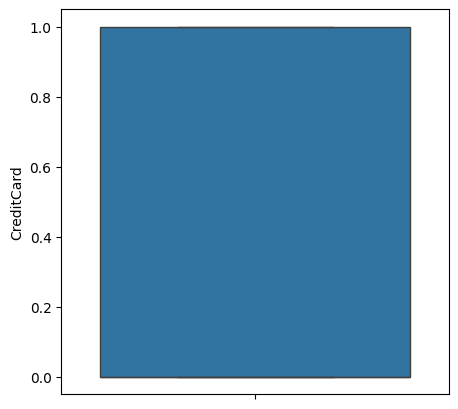

In [11]:
import seaborn as sns
for i in df.columns:
  plt.figure(figsize=(5,5))
  sns.boxplot(df[i])
  plt.show()

In [15]:
!pip install joblib

In [25]:
import os
import kagglehub
import pandas as pd
import joblib

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

# Save dir
SAVEDIR = os.getenv('ARTIFACT_DIR', '.') + '/saved_models'
os.makedirs(SAVEDIR, exist_ok=True)

def load_data():
    path = kagglehub.dataset_download("itsmesunil/bank-loan-modelling")
    df = pd.read_excel(
        os.path.join(path, "Bank_Personal_Loan_Modelling.xlsx"),
        sheet_name='Data'
    )
    # DROP via keyword axis=
    return df.drop(['ID', 'ZIP Code'], axis=1)

def split_data(df):
    X = df.drop('Personal Loan', axis=1)
    y = df['Personal Loan']
    X0, X_test, y0, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X0, y0, test_size=0.2, stratify=y0, random_state=42
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

def preprocess_fit(X_train, X_val, X_test):
    rb = ['CCAvg','Mortgage']
    st = ['Income','Experience','Age']
    pt = PowerTransformer('yeo-johnson')
    rs = RobustScaler()
    ss = StandardScaler()

    # fit & transform train
    X_train[rb] = rs.fit_transform(pt.fit_transform(X_train[rb]))
    X_train[st] = ss.fit_transform(X_train[st])

    # transform val/test
    for X in (X_val, X_test):
        X[rb] = rs.transform(pt.transform(X[rb]))
        X[st] = ss.transform(X[st])

    # save transformers
    joblib.dump(pt, os.path.join(SAVEDIR, 'pt.pkl'))
    joblib.dump(rs, os.path.join(SAVEDIR, 'rs.pkl'))
    joblib.dump(ss, os.path.join(SAVEDIR, 'ss.pkl'))

    return X_train, X_val, X_test

def feature_select_fit(X_train, y_train, X_val, X_test):
    selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=8)
    Xtr = selector.fit_transform(X_train, y_train)
    Xv  = selector.transform(X_val)
    Xt  = selector.transform(X_test)
    joblib.dump(selector, os.path.join(SAVEDIR, 'selector.pkl'))
    return Xtr, Xv, Xt

def balance(X, y):
    sm = SMOTE(random_state=42)
    return sm.fit_resample(X, y)

def tune_and_save(X, y):
    grids = {
        'LogisticRegression': {
            'model': LogisticRegression(max_iter=1000),
            'params': {'C':[0.01,0.1,1,10], 'penalty':['l1','l2'], 'solver':['liblinear']}
        },
        'DecisionTree': {
            'model': DecisionTreeClassifier(),
            'params': {'max_depth':[3,5,7,None], 'min_samples_split':[2,5,10], 'min_samples_leaf':[1,2,4]}
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {'n_estimators':[50,100], 'max_depth':[5,10,None]}
        },
        'GradientBoosting': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {'n_estimators':[50,100], 'learning_rate':[0.01,0.1]}
        },
        'KNN': {
            'model': KNeighborsClassifier(),
            'params': {'n_neighbors':[3,5,7]}
        },
        'SVM': {
            'model': SVC(probability=True, random_state=42),
            'params': {'C':[0.1,1,10], 'kernel':['linear','rbf']}
        }
    }

    for name, cfg in grids.items():
        gs = GridSearchCV(cfg['model'], cfg['params'], scoring='f1', cv=5, n_jobs=-1)
        gs.fit(X, y)
        joblib.dump(gs.best_estimator_, os.path.join(SAVEDIR, f"{name}_model.pkl"))
        print(f"{name} tuned → {gs.best_params_}")

def main():
    df = load_data()
    Xtr, Xv, Xt, ytr, yv, yt = split_data(df)
    Xtr, Xv, Xt = preprocess_fit(Xtr, Xv, Xt)
    Xtf, Xvf, Xsf = feature_select_fit(Xtr, ytr, Xv, Xt)
    Xb, yb = balance(Xtf, ytr)
    tune_and_save(Xb, yb)

if __name__=='__main__':
    main()

LogisticRegression tuned → {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
DecisionTree tuned → {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
RandomForest tuned → {'max_depth': None, 'n_estimators': 100}
GradientBoosting tuned → {'learning_rate': 0.1, 'n_estimators': 100}
KNN tuned → {'n_neighbors': 3}
SVM tuned → {'C': 10, 'kernel': 'rbf'}


In [26]:
!ls -l saved_models

!zip -r models.zip saved_models

total 3196
-rw-r--r-- 1 root root   12585 Jun 30 10:27 DecisionTree_model.pkl
-rw-r--r-- 1 root root  142952 Jun 30 10:28 GradientBoosting_model.pkl
-rw-r--r-- 1 root root  771190 Jun 30 10:28 KNN_model.pkl
-rw-r--r-- 1 root root     939 Jun 30 10:27 LogisticRegression_model.pkl
-rw-r--r-- 1 root root    1149 Jun 30 10:27 pt.pkl
-rw-r--r-- 1 root root 2282425 Jun 30 10:27 RandomForest_model.pkl
-rw-r--r-- 1 root root     535 Jun 30 10:27 rs.pkl
-rw-r--r-- 1 root root    1864 Jun 30 10:27 selector.pkl
-rw-r--r-- 1 root root     943 Jun 30 10:27 ss.pkl
-rw-r--r-- 1 root root   31467 Jun 30 10:28 SVM_model.pkl
  adding: saved_models/ (stored 0%)
  adding: saved_models/RandomForest_model.pkl (deflated 79%)
  adding: saved_models/pt.pkl (deflated 40%)
  adding: saved_models/DecisionTree_model.pkl (deflated 72%)
  adding: saved_models/rs.pkl (deflated 21%)
  adding: saved_models/ss.pkl (deflated 37%)
  adding: saved_models/GradientBoosting_model.pkl (deflated 72%)
  adding: saved_models/KNN_

In [28]:
!zip -r /content/saved_models.zip /content/saved_models

  adding: content/saved_models/ (stored 0%)
  adding: content/saved_models/RandomForest_model.pkl (deflated 79%)
  adding: content/saved_models/pt.pkl (deflated 40%)
  adding: content/saved_models/DecisionTree_model.pkl (deflated 72%)
  adding: content/saved_models/rs.pkl (deflated 21%)
  adding: content/saved_models/ss.pkl (deflated 37%)
  adding: content/saved_models/GradientBoosting_model.pkl (deflated 72%)
  adding: content/saved_models/KNN_model.pkl (deflated 78%)
  adding: content/saved_models/LogisticRegression_model.pkl (deflated 33%)
  adding: content/saved_models/SVM_model.pkl (deflated 74%)
  adding: content/saved_models/selector.pkl (deflated 45%)
